# Install and Import Packages
```pip install opencv-contrib-python```

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Generate Sample Marker

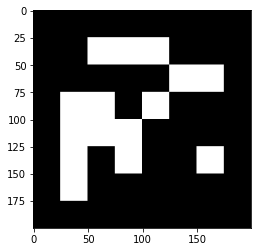

In [2]:
dictionary = cv2.aruco.Dictionary_get(cv2.aruco.DICT_6X6_250)

marker = cv2.aruco.drawMarker(dictionary, id=249, sidePixels=200)

plt.imshow(marker, cmap='gray')

# Generate 4 Markers and Save it to files

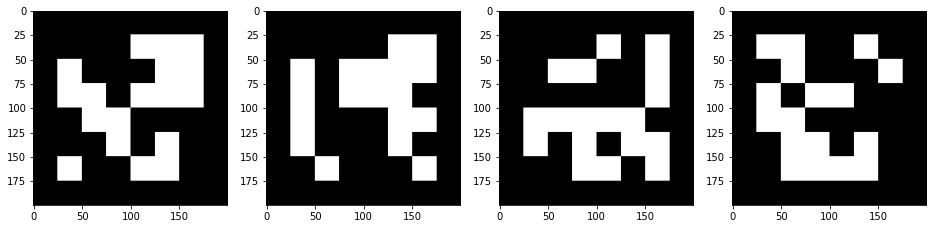

In [3]:
os.makedirs('markers', exist_ok=True)

fig, ax = plt.subplots(1, 4, figsize=(16, 10))

for i in range(4):
    marker = cv2.aruco.drawMarker(dictionary, id=i, sidePixels=200)

    cv2.imwrite('markers/marker_%d.png' % (i), marker)
    
    ax[i].imshow(marker, cmap='gray')

# Load Destination Image

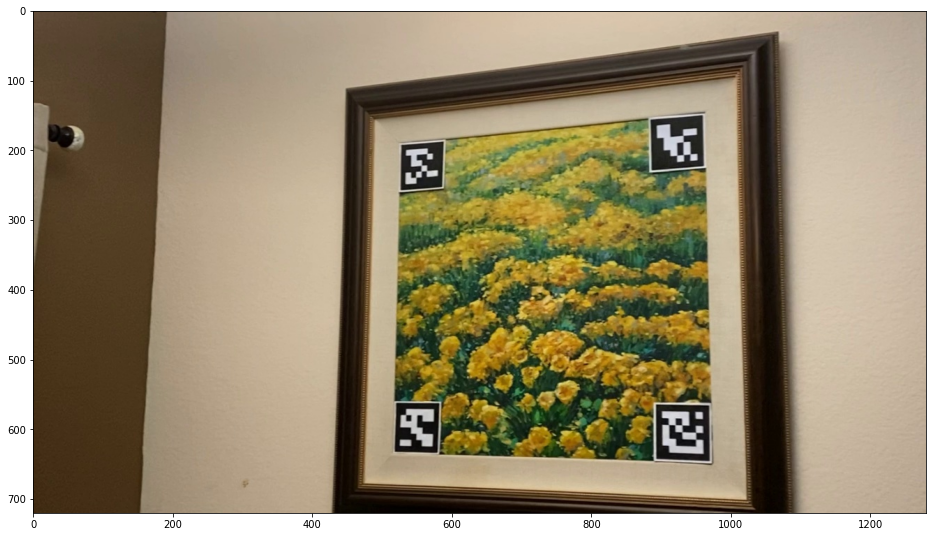

In [4]:
frame = cv2.imread('imgs/test.jpg')

fig, ax = plt.subplots(1, figsize=(16, 10))
ax.imshow(frame[:, :, ::-1])

# Detect Markers

In [10]:
marker_corners, marker_ids, _ = cv2.aruco.detectMarkers(
    frame,
    dictionary,
    parameters=cv2.aruco.DetectorParameters_create()
)

print(marker_ids)
print(marker_corners)

[[30]
 [23]
 [25]
 [33]]
[array([[[969., 645.],
        [893., 641.],
        [893., 565.],
        [968., 566.]]], dtype=float32), array([[[518., 631.],
        [521., 562.],
        [582., 563.],
        [579., 633.]]], dtype=float32), array([[[527., 257.],
        [528., 193.],
        [588., 188.],
        [586., 252.]]], dtype=float32), array([[[887., 229.],
        [885., 157.],
        [959., 151.],
        [961., 222.]]], dtype=float32)]


# Check Location of Markers
- top left: 25
- top right: 33
- bottom left: 23
- bottom right: 30

[[[969 645]
  [893 641]
  [893 565]
  [968 566]]

 [[518 631]
  [521 562]
  [582 563]
  [579 633]]

 [[527 257]
  [528 193]
  [588 188]
  [586 252]]

 [[887 229]
  [885 157]
  [959 151]
  [961 222]]]


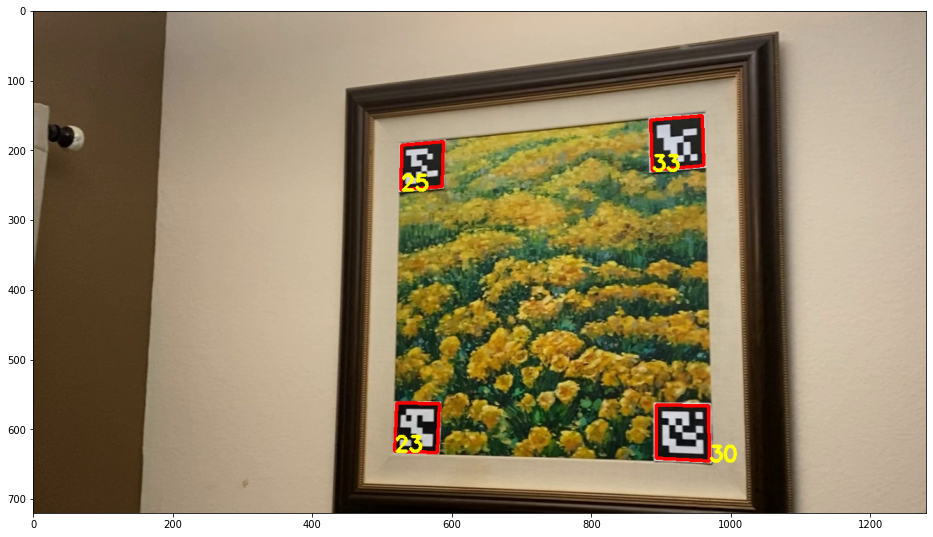

In [12]:
frame_copy = frame.copy()

marker_ids = marker_ids.reshape((-1,))
marker_corners = np.array(marker_corners, dtype=np.int).reshape((-1, len(marker_ids), 2))

for marker_id, marker_corner in zip(marker_ids, marker_corners):
    cv2.polylines(frame_copy, pts=[marker_corner], isClosed=True, color=(0, 0, 255), thickness=3)
    cv2.putText(frame_copy, str(marker_id), org=tuple(marker_corner[0]), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0, 255, 255), thickness=3)

fig, ax = plt.subplots(1, figsize=(16, 10))
ax.imshow(frame_copy[:, :, ::-1])

# Simple Math

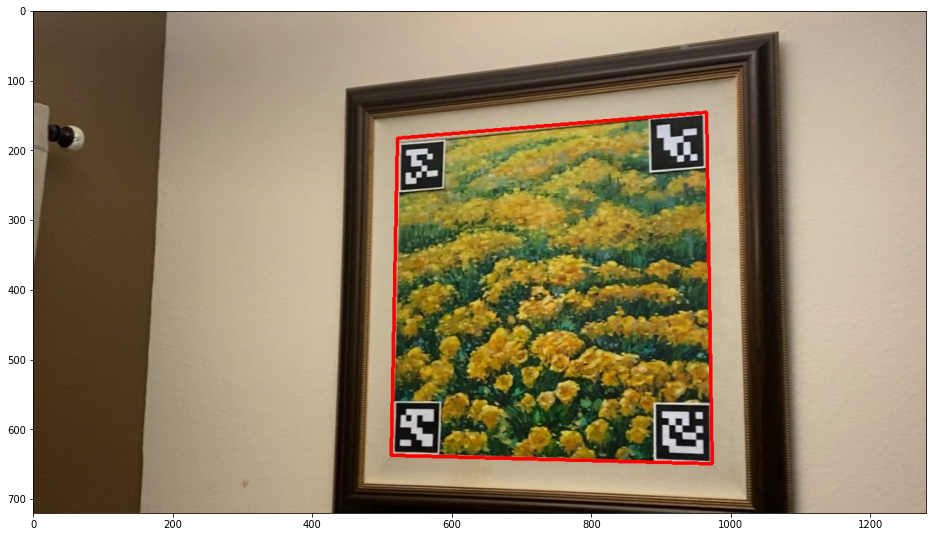

In [7]:
top_left_x, top_left_y = np.min(marker_corners[list(marker_ids).index(25)], axis=0)

top_right_x, _ = np.max(marker_corners[list(marker_ids).index(33)], axis=0)
_, top_right_y = np.min(marker_corners[list(marker_ids).index(33)], axis=0)

bottom_right_x, bottom_right_y = np.max(marker_corners[list(marker_ids).index(30)], axis=0)

bottom_left_x, _ = np.min(marker_corners[list(marker_ids).index(23)], axis=0)
_, bottom_left_y = np.max(marker_corners[list(marker_ids).index(23)], axis=0)

# add margin for better looking
margin = (top_right_x - top_left_x) * 0.01

dst_pts = np.array([
    [top_left_x - margin, top_left_y - margin],
    [top_right_x + margin, top_right_y - margin],
    [bottom_right_x + margin, bottom_right_y + margin],
    [bottom_left_x - margin, bottom_left_y + margin],
], dtype=np.int)

frame_copy = frame.copy()

cv2.polylines(frame_copy, pts=[dst_pts], isClosed=True, color=(0, 0, 255), thickness=3)

fig, ax = plt.subplots(1, figsize=(16, 10))
ax.imshow(frame_copy[:, :, ::-1])

# Load Source Image

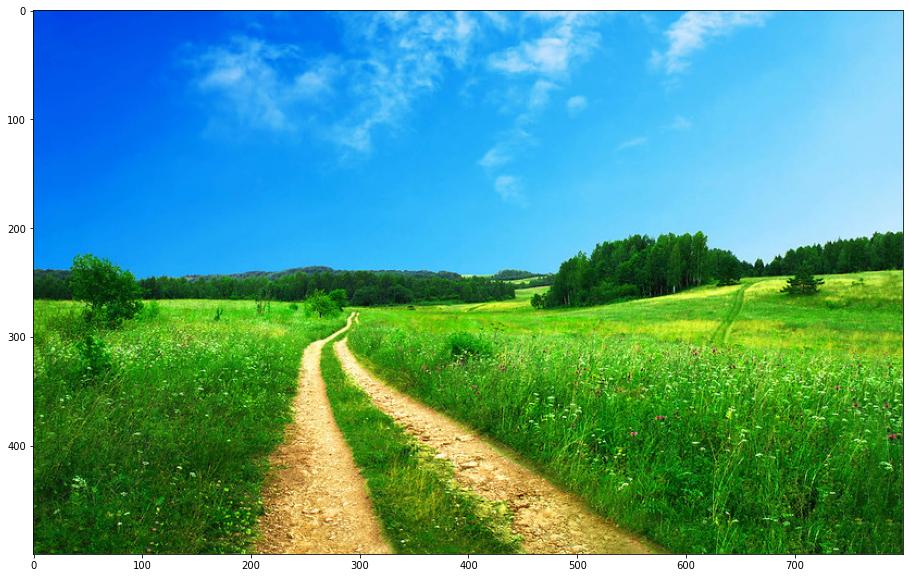

In [9]:
src_img = cv2.imread('imgs/new_scenery.jpg')

fig, ax = plt.subplots(1, figsize=(16, 10))
ax.imshow(src_img[:, :, ::-1])

# Perspective Transform

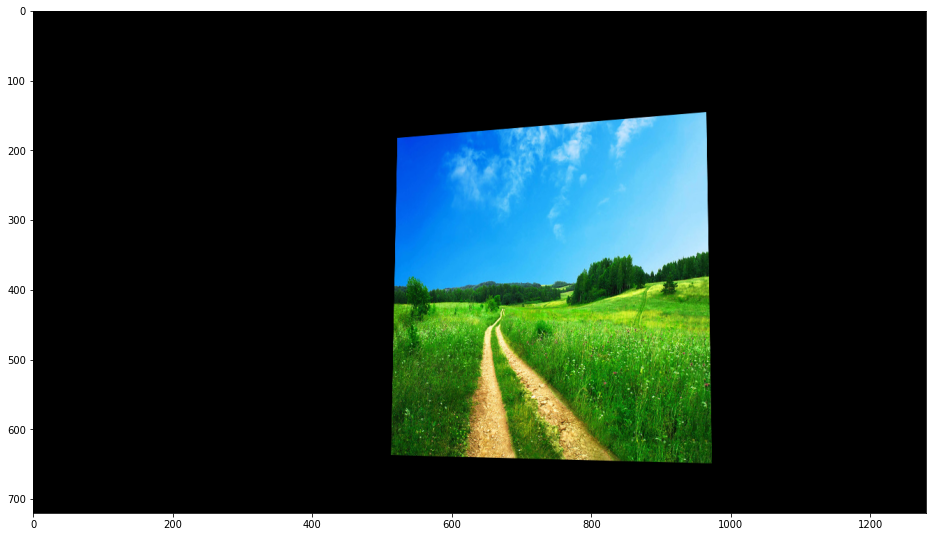

In [10]:
src_np = np.array([
    [0, 0],
    [src_img.shape[1], 0],
    [src_img.shape[1], src_img.shape[0]],
    [0, src_img.shape[0]]
], dtype=np.float32)

dst_np = dst_pts.astype(np.float32)

M = cv2.getPerspectiveTransform(src=src_np, dst=dst_np)
result_pt = cv2.warpPerspective(src_img, M=M, dsize=(frame.shape[1], frame.shape[0]))

fig, ax = plt.subplots(1, figsize=(16, 10))
ax.imshow(result_pt[:, :, ::-1])

# Mask

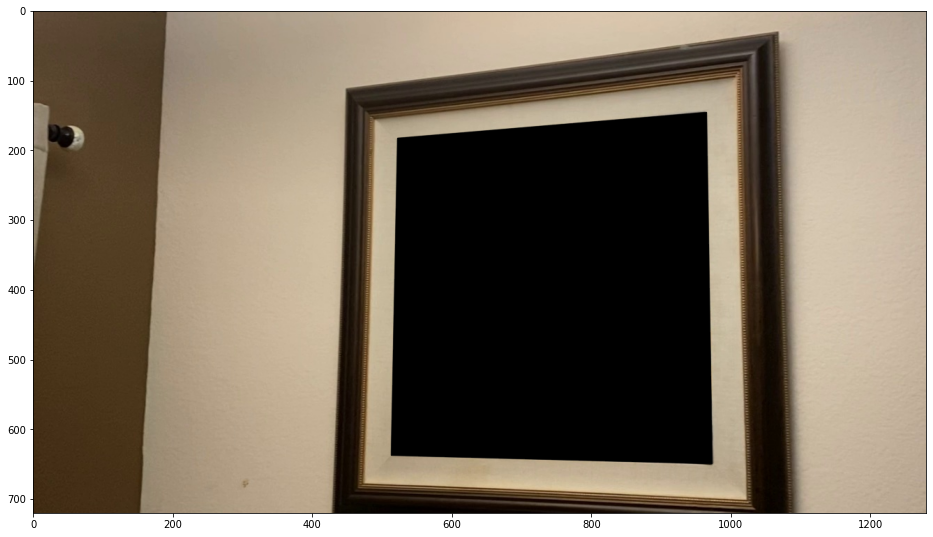

In [11]:
frame_copy = frame.copy()

cv2.fillPoly(frame_copy, pts=[dst_pts], color=0, lineType=cv2.LINE_AA)

fig, ax = plt.subplots(1, figsize=(16, 10))
ax.imshow(frame_copy[:, :, ::-1])

# Result

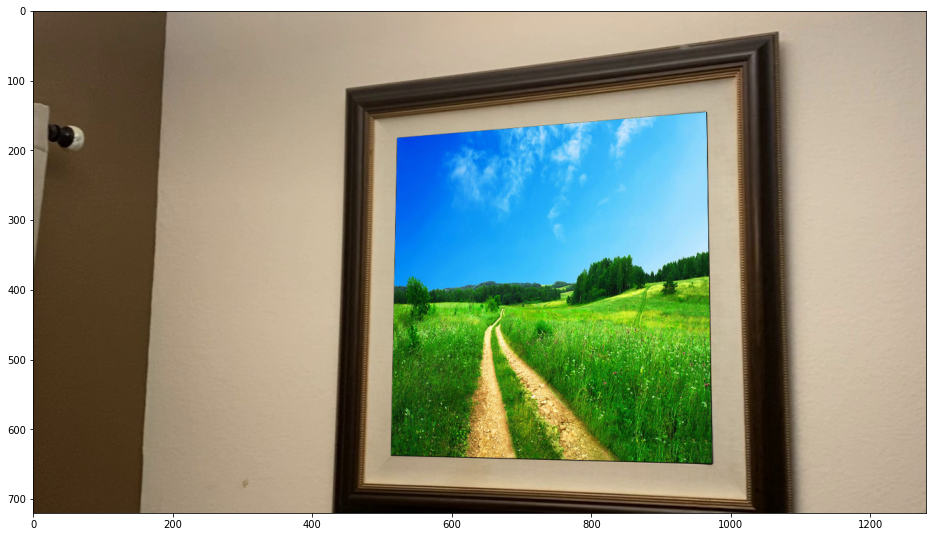

In [20]:
result = (frame_copy + result_pt)

fig, ax = plt.subplots(1, figsize=(16, 10))
ax.imshow(result[:, :, ::-1])